In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from compoundeye.evaluation import evaluate

import numpy as np
import matplotlib.pyplot as plt

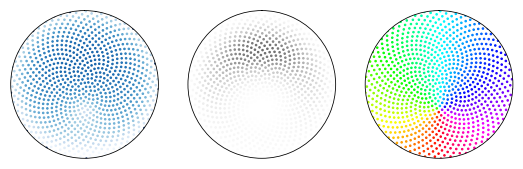

In [2]:
%matplotlib inline
from compoundeye.geometry import fibonacci_sphere
from environment import Sky
from notebooks.plots import plot_sky

samples = 1000

theta, phi = fibonacci_sphere(samples, 180)
sky = Sky(np.pi/6, np.pi)
y, p, a = sky(theta, phi)

plt.figure("sky", figsize=(9, 3))
plot_sky(phi, theta, y, p, a).show()

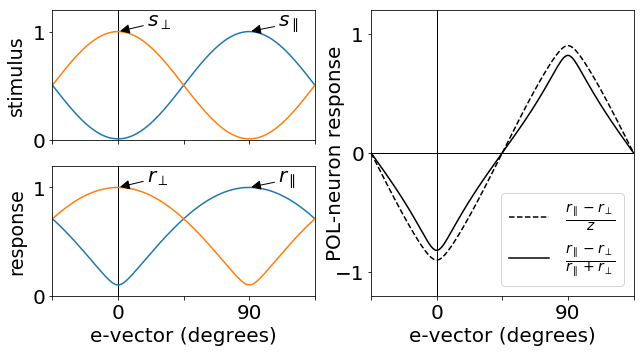

In [3]:
from notebooks.plots import plot_pol_neurons_rotating_linear_polariser

Y = 7.5  # light intensity
pol = .9  # degree of polarasation
e = np.linspace(-np.pi / 4, 3 * np.pi / 4, 361)  # e-vector orientation
act_func = np.sqrt  # activation function

s_1 = Y * (np.square(np.cos(e)) + np.square(np.sin(e)) * np.square(1. - pol))
s_2 = Y * (np.square(np.sin(e)) + np.square(np.cos(e)) * np.square(1. - pol))

r_1 = act_func(s_1)
r_2 = act_func(s_2)

z = act_func(Y)
r_z = (r_2 - r_1) / z
r_pol = (r_2 - r_1) / (r_2 + r_1)

plt.figure("photoreceptors", figsize=(9, 5))
plot_pol_neurons_rotating_linear_polariser(
    [np.rad2deg(e), s_1 / Y], [np.rad2deg(e), s_2 / Y],
    [np.rad2deg(e), r_1 / z], [np.rad2deg(e), r_2 / z],
    [np.rad2deg(e), r_z], [np.rad2deg(e), r_pol]).show()

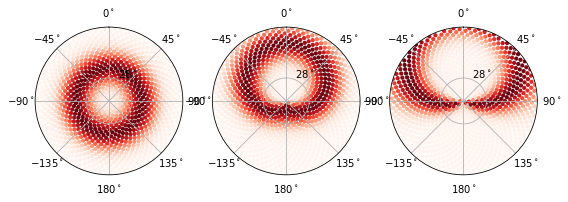

In [4]:
from notebooks.plots import plot_gate_ring

plt.figure("gate-ring", figsize=(9, 3))
plot_gate_ring(theta_t=np.deg2rad(0), subplot=131)
plot_gate_ring(theta_t=np.deg2rad(30), subplot=132)
plot_gate_ring(theta_t=np.deg2rad(60), subplot=133).show()

In [6]:


def evaluate(n=60, omega=56, sigma_pol=np.deg2rad(13), shift_pol=np.deg2rad(40),
             noise=0.,
             nb_cl1=8, 
             nb_tb1=8,
             use_default=False,
             weighted=True,
             fibonacci=False,
             uniform_polariser=False,

             # single evaluation
             sun_azi=None, sun_ele=None,

             # data parameters
             tilting=True, ephemeris=False,
             samples=1000, show_plots=False, show_structure=False, verbose=False):

    # default parameters
    tau_L = 2.
    c1 = .6
    c2 = 4.
    AA, BB, CC, DD, EE = T_L.dot(np.array([tau_L, 1.]))  # sky parameters
    T_T = np.linalg.pinv(T_L)
    tau_L, c = T_T.dot(np.array([AA, BB, CC, DD, EE]))
    tau_L /= c  # turbidity correction

    # Prez. et. al. Luminance function
    def L(cchi, zz):
        ii = zz < (np.pi/2)
        ff = np.zeros_like(zz)
        if zz.ndim > 0:
            ff[ii] = (1. + AA * np.exp(BB / (np.cos(zz[ii]) + eps)))
        elif ii:
            ff = (1. + AA * np.exp(BB / (np.cos(zz) + eps)))
        pphi = (1. + CC * np.exp(DD * cchi) + EE * np.square(np.cos(cchi)))
        return ff * pphi

    if tilting is not None and type(tilting) is tuple:
        angles = np.array([tilting])  # 1
    elif tilting:
        angles = np.array([
            [0., 0.],
            [np.pi / 6, 0.], [np.pi / 6, np.pi / 4], [np.pi / 6, 2 * np.pi / 4], [np.pi / 6, 3 * np.pi / 4],
            [np.pi / 6, 4 * np.pi / 4], [np.pi / 6, 5 * np.pi / 4], [np.pi / 6, 6 * np.pi / 4],
            [np.pi / 6, 7 * np.pi / 4],
            [np.pi / 3, 0.], [np.pi / 3, np.pi / 4], [np.pi / 3, 2 * np.pi / 4], [np.pi / 3, 3 * np.pi / 4],
            [np.pi / 3, 4 * np.pi / 4], [np.pi / 3, 5 * np.pi / 4], [np.pi / 3, 6 * np.pi / 4],
            [np.pi / 3, 7 * np.pi / 4]
        ])  # 17
        if samples == 1000:
            samples /= 2
    else:
        angles = np.array([[0., 0.]])  # 1

    # generate the different sun positions
    if sun_azi is not None or sun_ele is not None:
        theta_s = sun_ele if type(sun_ele) is np.ndarray else np.array([sun_ele])
        phi_s = sun_azi if type(sun_azi) is np.ndarray else np.array([sun_azi])
    else:
        theta_s, phi_s = fibonacci_sphere(samples=samples, fov=161)
        phi_s = phi_s[theta_s <= np.pi / 2]
        theta_s = theta_s[theta_s <= np.pi / 2]
    samples = theta_s.size

    # generate the properties of the sensor
    try:
        theta, phi, fit = angles_distribution(n, float(omega))
    except ValueError:
        theta = np.empty(0, dtype=np.float32)
        phi = np.empty(0, dtype=np.float32)
        fit = False

    if not fit or n > 100 or fibonacci:
        theta, phi = fibonacci_sphere(n, float(omega))
    # theta, phi, fit = angles_distribution(n, omega)
    # if not fit:
    #     print theta.shape, phi.shape
    theta = (theta - np.pi) % (2 * np.pi) - np.pi
    phi = (phi + np.pi) % (2 * np.pi) - np.pi
    alpha = (phi + np.pi/2) % (2 * np.pi) - np.pi

    # computational model parameters
    phi_cl1 = np.linspace(0., 2 * np.pi, nb_cl1, endpoint=False)  # CL1 preference angles
    phi_tb1 = np.linspace(0., 2 * np.pi, nb_tb1, endpoint=False)  # TB1 preference angles

    # initialise lists for the statistical data
    d = np.zeros((samples, angles.shape[0]), dtype=np.float32)
    t = np.zeros_like(d)
    d_eff = np.zeros((samples, angles.shape[0]), dtype=np.float32)
    a_ret = np.zeros_like(t)
    tb1 = np.zeros((samples, angles.shape[0], nb_tb1), dtype=np.float32)

    # iterate through the different tilting angles
    for j, (theta_t, phi_t) in enumerate(angles):
        # transform relative coordinates
        theta_s_, phi_s_ = tilt(theta_t, phi_t, theta=theta_s, phi=phi_s)
        theta_, phi_ = tilt(theta_t, phi_t + np.pi, theta=theta, phi=phi)
        _, alpha_ = tilt(theta_t, phi_t + np.pi, theta=np.pi / 2, phi=alpha)

        for i, (e, a, e_org, a_org) in enumerate(zip(theta_s_, phi_s_, theta_s, phi_s)):

            # SKY INTEGRATION
            gamma = np.arccos(np.cos(theta_) * np.cos(e_org) + np.sin(theta_) * np.sin(e_org) * np.cos(phi_ - a_org))
            # Intensity
            I_prez, I_00, I_90 = L(gamma, theta_), L(0., e_org), L(np.pi / 2, np.absolute(e_org - np.pi / 2))
            # influence of sky intensity
            I = (1. / (I_prez + eps) - 1. / (I_00 + eps)) * I_00 * I_90 / (I_00 - I_90 + eps)
            chi = (4. / 9. - tau_L / 120.) * (np.pi - 2 * e_org)
            Y_z = (4.0453 * tau_L - 4.9710) * np.tan(chi) - 0.2155 * tau_L + 2.4192
            if uniform_polariser:
                Y = np.maximum(np.full_like(I_prez, Y_z), 0.)
            else:
                Y = np.maximum(Y_z * I_prez / (I_00 + eps), 0.)  # Illumination

            # Degree of Polarisation
            M_p = np.exp(-(tau_L - c1) / (c2 + eps))
            LP = np.square(np.sin(gamma)) / (1 + np.square(np.cos(gamma)))
            if uniform_polariser:
                P = np.ones_like(LP)
            else:
                P = np.clip(2. / np.pi * M_p * LP * (theta_ * np.cos(theta_) + (np.pi/2 - theta_) * I), 0., 1.)

            # Angle of polarisation
            if uniform_polariser:
                A = np.full_like(P, a_org + np.pi)
            else:
                _, A = tilt(e_org, a_org + np.pi, theta_, phi_)

            # create cloud disturbance
            if type(noise) is np.ndarray:
                if noise.size == P.size:
                    # print ("yeah!")
                    eta = np.array(noise, dtype=bool)
                else:
                    eta = np.zeros_like(theta, dtype=bool)
                    eta[:noise.size] = noise
            elif noise > 0:
                eta = np.argsort(np.absolute(np.random.randn(*P.shape)))[:int(noise * P.shape[0])]
                # eta = np.array(np.absolute(np.random.randn(*P.shape)) < noise, dtype=bool)
                if verbose:
                    print ("Noise level: %.4f (%.2f %%)" % (noise, 100. * eta.sum() / float(eta.size)))
            else:
                eta = np.zeros_like(theta, dtype=bool)
            P[eta] = 0.  # destroy the polarisation pattern

            # COMPUTATIONAL MODEL

            # Input (POL) layer -- Photo-receptors
            y = spectrum_influence(Y, spectrum["uv"])
            s_1 = y * (np.square(np.sin(A - alpha_)) + np.square(np.cos(A - alpha_)) * np.square(1. - P))
            s_2 = y * (np.square(np.cos(A - alpha_)) + np.square(np.sin(A - alpha_)) * np.square(1. - P))
            r_1, r_2 = np.sqrt(s_1), np.sqrt(s_2)
            # r_1, r_2 = np.log(s_1 + 1.), np.log(s_2 + 1.)
            r_opo, r_sol = r_1 - r_2, r_1 + r_2
            r_pol = r_opo / (r_sol + eps)
            # r_sol = 2. * r_sol / np.max(r_sol) - 1.

            # Tilting (SOL) layer
            d_pol = (np.sin(shift_pol - theta) * np.cos(theta_t) +
                     np.cos(shift_pol - theta) * np.sin(theta_t) *
                     np.cos(phi - phi_t))
            gate_pol = np.power(np.exp(-np.square(d_pol) / (2. * np.square(sigma_pol))), 1)
            z_pol = float(nb_cl1) / float(n)
            w_cl1_pol = z_pol * np.sin(alpha[:, np.newaxis] - phi_cl1[np.newaxis]) * gate_pol[:, np.newaxis]

            # d_sol = (np.sin(shift_sol - theta) * np.cos(theta_t) +
            #          np.cos(shift_sol - theta) * np.sin(theta_t) *
            #          np.cos(phi - phi_t))
            # gate_sol = np.power(np.exp(-np.square(d_sol) / (2. * np.square(sigma_sol))), 1)
            # z_sol = float(nb_cl1) / float(n)
            # w_cl1_sol = z_sol * np.sin(phi_cl1[np.newaxis] - alpha[:, np.newaxis]) * gate_sol[:, np.newaxis]

            # o = 1./64.
            r_cl1_pol = r_pol.dot(w_cl1_pol)
            # r_cl1_sol = r_sol.dot(w_cl1_sol)
            # f_pol, f_sol = .5 * np.power(2*theta_t/np.pi, o), .5 * (1 - np.power(2*theta_t/np.pi, o))
            # r_cl1 = f_pol * r_cl1_pol + f_sol * r_cl1_sol
            r_cl1 = r_cl1_pol

            # Output (TB1) layer
            eph = (a - np.pi/3) if ephemeris else 0.
            w_tb1 = float(nb_tb1) / float(nb_cl1 * 2.) * np.cos(phi_tb1[np.newaxis] - phi_cl1[:, np.newaxis] + eph)

            # r_tb1 = r_cl1.dot(w_tb1)
            r_tb1 = r_cl1.dot(w_tb1)

            if use_default:
                w = -float(nb_tb1) / (2. * float(n)) * np.sin(
                    phi_tb1[np.newaxis] - alpha[:, np.newaxis]) * gate_pol[:, np.newaxis]
                r_tb1 = r_pol.dot(w)

            # decode response - FFT
            R = r_tb1.dot(np.exp(-np.arange(nb_tb1) * (0. + 1.j) * 2. * np.pi / float(nb_tb1)))
            a_pred = (np.pi - np.arctan2(R.imag, R.real)) % (2. * np.pi) - np.pi  # sun azimuth (prediction)
            tau_pred = np.absolute(R)  # certainty of prediction

            d[i, j] = np.absolute(azidist(np.array([e, a]), np.array([0., a_pred])))
            t[i, j] = tau_pred if weighted else 1.
            a_ret[i, j] = a_pred
            tb1[i, j] = r_tb1

            # effective degree of polarisation
            M = r_cl1.max() - r_cl1.min()
            # M = t[i, j] * 2.
            p = np.power(10, M/2.)
            d_eff[i, j] = np.mean((p - 1.) / (p + 1.))

            if show_plots:
                plt.figure("sensor-noise-%2d" % (100. * eta.sum() / float(eta.size)), figsize=(4.5, 9))
                x = np.linspace(0, 2 * np.pi, 721)

                ax = plt.subplot(6, 1, 4)
                plt.imshow(5 * w_cl1_pol.T, cmap="coolwarm", vmin=-1, vmax=1)
                plt.yticks([0, 7], ["1", "8"])
                plt.xticks([0, 59], ["1", "60"])

                ax.tick_params(axis='both', which='major', labelsize=16)
                ax.tick_params(axis='both', which='minor', labelsize=16)

                ax = plt.subplot(12, 1, 9)  # , sharey=ax)
                plt.imshow(w_tb1.T, cmap="coolwarm", vmin=-1, vmax=1)
                plt.xticks([0, 7], ["1", "8"])
                plt.yticks([0, 7], ["1", "8"])
                # cbar = plt.colorbar(ticks=[-1, 0, 1], orientation='vertical')
                # cbar.ax.set_yticklabels([r'$\leq$ -1', r'0', r'$\geq$ 1'])

                ax.tick_params(axis='both', which='major', labelsize=16)
                ax.tick_params(axis='both', which='minor', labelsize=16)

                ax = plt.subplot(2, 1, 1, polar=True)
                ax.set_theta_zero_location("N")
                ax.set_theta_direction(-1)
                ax.grid(False)

                # POL
                ax.scatter(phi, theta, s=90, c=r_pol, marker='o', edgecolor='black', cmap="coolwarm", vmin=-1, vmax=1)

                # SOL
                y = np.deg2rad(37.5)
                sy = np.deg2rad(15)
                ax.fill_between(x, np.full_like(x, y - sy/2), np.full_like(x, y + sy/2),
                                facecolor="C1", alpha=.5, label="SOL")
                ax.scatter(phi_cl1, np.full(nb_cl1, np.deg2rad(37.5)), s=600,
                           c=r_cl1, marker='o', edgecolor='red', cmap="coolwarm", vmin=-1, vmax=1)

                for ii, pp in enumerate(phi_cl1):
                    ax.text(pp - np.pi/13, y, "%d" % (ii + 1), ha="center", va="center", size=10,
                            bbox=dict(boxstyle="circle", fc="w", ec="k"))
                    ax.arrow(pp, np.deg2rad(33), 0, np.deg2rad(4), fc='k', ec='k',
                             head_width=.1, head_length=.1, overhang=.3)

                # TCL
                y = np.deg2rad(52.5)
                sy = np.deg2rad(15)
                ax.fill_between(x, np.full_like(x, y - sy/2), np.full_like(x, y + sy/2),
                                facecolor="C2", alpha=.5, label="TCL")
                ax.scatter(phi_tb1, np.full_like(phi_tb1, y), s=600,
                           c=r_tb1, marker='o', edgecolor='green', cmap="coolwarm", vmin=-1, vmax=1)
                for ii, pp in enumerate(phi_tb1):
                    ax.text(pp + np.pi/18, y, "%d" % (ii + 1), ha="center", va="center", size=10,
                            bbox=dict(boxstyle="circle", fc="w", ec="k"))
                    pref = a if ephemeris else 0.
                    print ("Sun:", np.rad2deg(pref))
                    dx, dy = np.deg2rad(4) * np.sin(0.), np.deg2rad(4) * np.cos(0.)
                    ax.arrow(pp - dx, y - dy/2 - np.deg2rad(2.5), dx, dy, fc='k', ec='k',
                             head_width=.07, head_length=.1, overhang=.3)

                # Sun position
                ax.scatter(a, e, s=500, marker='o', edgecolor='black', facecolor='yellow')
                ax.scatter(phi_t, theta_t, s=200, marker='o', edgecolor='black', facecolor='yellowgreen')

                # Decoded TB1
                # ax.plot([0, a_pred], [0, e_pred], 'k--', lw=1)
                ax.plot([0, a_pred], [0, np.pi/2], 'k--', lw=1)
                ax.arrow(a_pred, 0, 0, np.deg2rad(20),
                         fc='k', ec='k', head_width=.3, head_length=.2, overhang=.3)

                ax.legend(ncol=2, loc=(.15, -1.), fontsize=16)

                ax.set_ylim([0, np.deg2rad(60)])
                ax.set_yticks([])
                ax.set_xticks(np.linspace(0, 2*np.pi, 4, endpoint=False))
                ax.set_xticklabels([r'N', r'E', r'S', r'W'])
                ax.tick_params(axis='both', which='major', labelsize=16)
                ax.tick_params(axis='both', which='minor', labelsize=16)

                plt.subplots_adjust(left=.07, bottom=.0, right=.93, top=.96)

                plt.show()

    d_deg = np.rad2deg(d)

    if show_structure:
        plt.figure("sensor-structure", figsize=(4.5, 4.5))
        ax = plt.subplot(111, polar=True)
        ax.scatter(phi, theta, s=150, c="black", marker='o')
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_ylim([0, np.deg2rad(50)])
        ax.set_yticks([])
        ax.set_xticks(np.linspace(-3 * np.pi / 4, 5 * np.pi / 4, 8, endpoint=False))
        ax.set_title("POL Response")
        plt.show()

    return d_deg, d_eff, t, a_ret, tb1


/mnt/c/Users/hunga/Google Drive/ed_proj/insectvision/notebooks/plots.py:137: RuntimeWarning: invalid value encountered in arcsin
  ele_pred = 26 * (1 - 2 * np.arcsin(1 - res) / np.pi) + 15  # + np.random.randn(res.size)


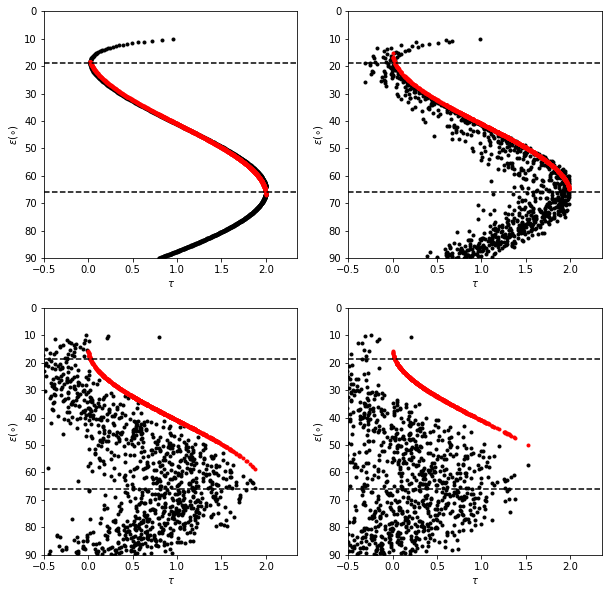

In [7]:
from notebooks.plots import plot_res2ele

plt.figure("res2ele", figsize=(10, 10))
plot_res2ele(noise=0.00, subplot=221)
plot_res2ele(noise=0.06, subplot=222)
plot_res2ele(noise=0.26, subplot=223)
plot_res2ele(noise=0.43, subplot=224).show()

Error: 3.2521 +/- 0.1002
| N = 869


<Figure size 720x720 with 0 Axes>

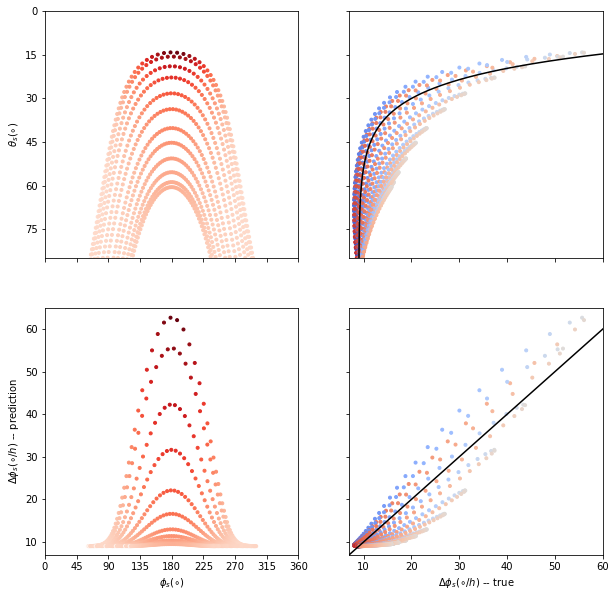

In [8]:
from environment import get_seville_observer
from notebooks.plots import plot_ephemeris

from datetime import datetime

obs = get_seville_observer()
obs.date = datetime.strptime("2018-06-21", "%Y-%m-%d")

plt.figure("ephemeris", figsize=(10, 10))
plot_ephemeris(obs).show()